# Imports

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
from NCA.NCA import *
import NCA.utils as utils
from IPython.display import Image, HTML, clear_output
import logging
import os
import cv2 
from IPython.display import Video
logger = logging.getLogger()
old_level = logger.level
logger.setLevel(100)

# Initial Setup 

In [2]:
DEVICE = "cuda:0" #<-- Device to use, CUA recommended 
HEIGHT = 30
WIDTH = 30
CHANNELS = 16 #<--- NCA feature channels
BATCH_SIZE = 12
PADDING = 5
GENE_COUNT = 8 #<-- Number of gene channels to use for "private" information 
POOL_SIZE = 2666 #<--- NCA training pool size, lower values train faster but are less stable
TRAINING_ITERS = 10000  #<-- Number of trainign iterations 
PRIMITIVES = ["../Images/square.png", "../Images/circle.png", "../Images/triangle.png"]
BODY_PARTS = ["../Images/Torso.png", "../Images/Head.png", "../Images/Tail.png", "../Images/leg1.png", "../Images/leg2.png", "../Images/leg3.png", "../Images/leg4.png"]
LINES = ["../Images/vertical.png", "../Images/horizontal.png"]
HIDDEN_N = 64

# Loading and Setting up Images

In [9]:
paths = LINES#<-- change between PRIMITIVES or BODY_PARTS 
images = []
images_to_display = []
for path in paths:
    image, image_to_display = utils.get_image(path, HEIGHT, WIDTH, padding=PADDING)
    images.append(image)
    images_to_display.append(image_to_display)
    
genes = [[0], [2]] # <-- Gene one hot encoding, indicates which bits if the gene sequence for each encoded "image" should be 1, [0] = 001, [0,1] = 011, [2] = 100 etc. for 3 bits genes. One, one-hot encoding per image, this rule applies for any gene size 

HEIGHT = HEIGHT + 2*PADDING
WIDTH = WIDTH + 2*PADDING
assert len(paths) >= len(genes), 'There should be as many or more images as genes'

# Displaying Images and Making Training Pools

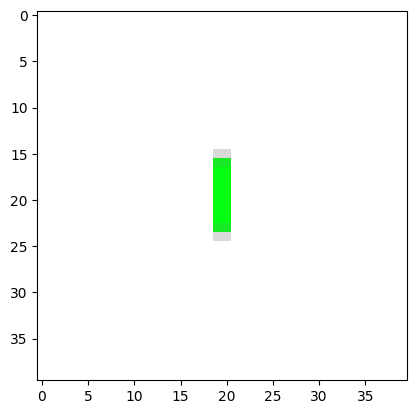

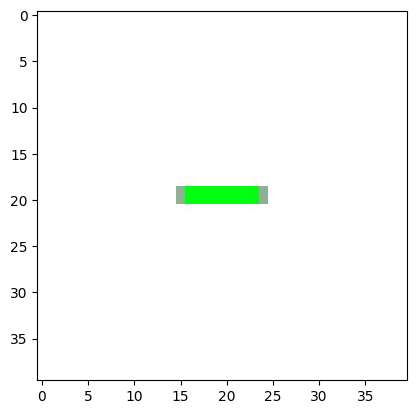

In [4]:
for i,image in enumerate(images_to_display):
    plt.figure(3+i)
    plt.imshow(image)
pools = []
for gene in genes:
    pools.append(utils.make_gene_pool(gene, pool_size=POOL_SIZE,height=HEIGHT, width=WIDTH, channels=CHANNELS, gene_size=8))
seeds = []
for pool in pools:
    seeds.append(pool[0].clone())



# Creating Batch Partitions for Every Image 

In [5]:
partitions = len(genes)
if partitions == 1:
    part = [BATCH_SIZE]
div = BATCH_SIZE//partitions
rem = BATCH_SIZE % partitions
part = [div + 1 if i < rem else div for i in range(partitions)]
print(part)

[6, 6]


# Filters for Loss Function

In [5]:
sobel_x = torch.tensor([[-1.0, 0.0, 1.0], [-2.0, 0.0, 2.0], [-1.0, 0.0, 1.0]], dtype=torch.float32, device="cuda:0")
lap = torch.tensor([[1.0, 2.0, 1.0], [2.0, -12, 2.0], [1.0, 2.0, 1.0]], dtype=torch.float32, device="cuda:0")
filters = torch.stack([sobel_x, sobel_x.T, lap])
folder = "Gene"


# Dirr Setup for Saving Models and Experimental Data 

In [6]:
def make_path(path):
    if not os.path.exists(path):
        os.makedirs(path)
        print(f"Path: {path} created")
    else: 
        print(f"Path: {path} already exists, all OK!")
    
path = "Trained_models/" + folder
make_path(path)
path = "Saved_Data/" + folder
make_path(path)

Path: Trained_models/Gene already exists, all OK!
Path: Saved_Data/Gene already exists, all OK!


# Setting Up NCA and Batched Target Image 

In [8]:
bases = [images[i].tile(part[i],1,1,1) for i in range(len(part))]
base = torch.cat(bases, dim =0 )
loss_log = []
nca = GeneCA(CHANNELS,HIDDEN_N, gene_size=GENE_COUNT)
nca = nca.to(DEVICE)
optim = torch.optim.AdamW(nca.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=5000, gamma=0.3)
name = folder + "/" +type(nca).__name__ + "_gene_size_" +str(GENE_COUNT)

# Training

Gene/GeneCA_gene_size_8


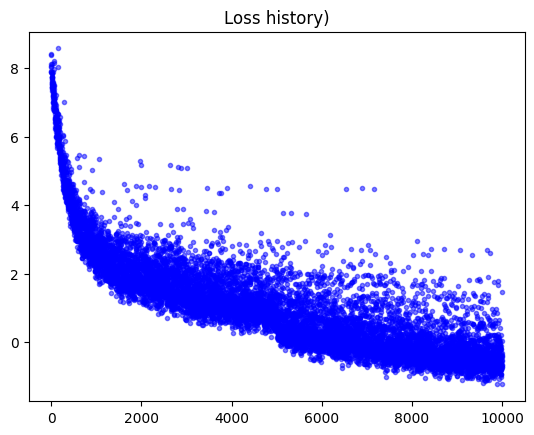

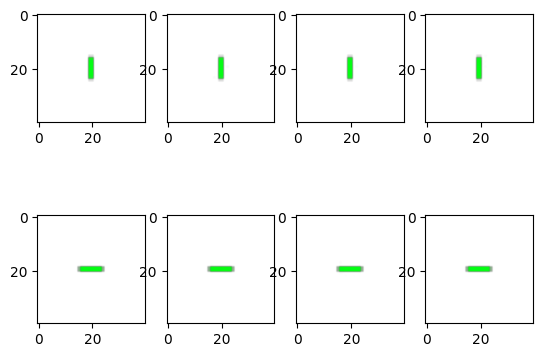

Trained_models/Gene/GeneCA_gene_size_8.pth


In [9]:
for i in range(TRAINING_ITERS + 1):
    loss = 0
    with torch.no_grad():
        idxs, x = utils.get_gene_pool(pools, part, seeds)

    for _ in range( random.randrange(32,92)):
        x = nca(x)
    loss = (base - x[:, :4, :, :]).pow(2).sum() + 0.1 *(perchannel_conv(base, filters) - perchannel_conv(x[:, :4, :, :], filters) ).pow(2).sum() 
    with torch.no_grad():
        loss.backward()
        for p in nca.parameters():
            p.grad /= (p.grad.norm() + 1e-8)
        optim.step()
        
        x = x.detach()
        optim.zero_grad()
    
    loss_log.append(loss.log().item())
    with torch.no_grad():   
        pools = utils.udate_gene_pool(pools, x.clone().detach(), idxs, part)
    scheduler.step()
    
    if i % 100 == 0:
        print(f"Training itter {i}, loss = {loss.item()}")
        plt.clf()
        clear_output()
        plt.figure(1,figsize=(10, 4))
        plt.title('Loss history)')
        print(name)
        plt.plot(loss_log, '.', alpha=0.5, color = "b")
        utils.show_batch(x[2:10])
        plt.show(block=False)
        plt.pause(0.01)
    if i % 100 == 0:
        torch.save(nca.state_dict(), "Trained_models/" + name + ".pth")
        print("Trained_models/" + name + ".pth")

np_logg = np.asarray(loss_log)
np.save("Saved_Data/" + name + "_data", np_logg)


# Video Utilities

In [11]:
path_video = "Saved_frames/GeneCA/GrowingPrimitives"

make_path(path_video)

def from_genes(genes, size, channels):
    seed = torch.zeros((channels), device=DEVICE)
    for gene_loc in genes:
        seed[channels-1-gene_loc] = 1
    seed[3:-size] = 1
    return seed

def place_seed(x, center_x, center_y, seeds, seed_index):
    x[:,3:-GENE_COUNT,center_x,center_y] = 1
    x[:,-len(seeds[seed_index]):,center_x,center_y] = seeds[seed_index]
    return x

def write_frame(x, path, frame_number, height, width, chn, text):
    font = cv2.FONT_HERSHEY_SIMPLEX
    org = (35, 35)
    fontScale = 1.4
    color = (255, 255, 255)
    thickness = 2
    image_np = x.clone().detach().cpu().permute(0,3,2,1).numpy().clip(0,1)[0,:,:,:3]
    image_np = cv2.resize(image_np, [500,500], cv2.INTER_CUBIC)
    image_np = cv2.putText(image_np, text, org, font,
                        fontScale, color, thickness, cv2.LINE_AA)
    image_np = cv2.resize(image_np, [height,width], cv2.INTER_CUBIC)
    plt.imsave(f"{path}/frame_{frame_number}.png", np.clip(image_np,0,1))

def make_video(path, total_frames, height, width):
    fourcc = cv2.VideoWriter_fourcc(*'VP80')
    out = cv2.VideoWriter(path+'/output_video.webm', fourcc, 30.0, (width, height))
    for frame_number in range(total_frames):
       frame_path = path+f"/frame_{frame_number}.png"
       frame = cv2.imread(frame_path)
       #frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

       out.write(frame)
    out.release()

Path: Saved_frames/GeneCA/GrowingPrimitives already exists, all OK!


# Growing All Primitives

In [16]:
#TODO: make all this a function and put it all in utils 
if "nca" in globals():
    del nca
if "optim" in globals():
    del optim
torch.cuda.empty_cache()
seeds = [from_genes(gene, GENE_COUNT, CHANNELS) for gene in genes]

seed_locs = [[40, 30], [40,90]]
assert len(seeds) == len(seed_locs), "there must be equal seed and seed locations"
seed_index = 0

nca = GeneCA(CHANNELS,hidden_n=HIDDEN_N, gene_size=GENE_COUNT)
nca.load_state_dict(torch.load("Trained_models/Gene/GeneCA_gene_size_8.pth"))
nca.to(DEVICE).eval()
x_prime = torch.zeros((1,CHANNELS, HEIGHT*3, WIDTH*3), dtype=torch.float32).cuda()
frame_count = 600
for i in range(frame_count):
    x_prime = nca(x_prime)
    if (i % 50 == 0) and (i//50 <= len(seeds)):
        place_seed(x_prime, seed_locs[seed_index][0], seed_locs[seed_index][1], seeds, seed_index)
        seed_index = (seed_index + 1) % len(seeds)
    x_prime = x_prime.detach()
    text = "Gene: " + str(seeds[seed_index][-1].item()) +" "+ str(seeds[seed_index][-2].item()) +" "+ str(
        seeds[seed_index][-3].item())
    write_frame(x_prime, path_video, i, HEIGHT*3, WIDTH*3,CHANNELS, text)
make_video(path_video, frame_count, HEIGHT*3, WIDTH*3)

/tmp/ipykernel_82858/690584489.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nca.load_state_dict(torch.load("Trained_models/Gene/GeneCA_gene_size_8.pth"))
OpenCV: FFM

In [17]:
Video(path_video+'/output_video.webm', embed=True, width=320, height=320)

# Growing Mixed Primitives

In [23]:
if "nca" in globals():
    del nca
path_video  = "Saved_frames/GeneCA/GrowingMixes"
make_path(path_video)
torch.cuda.empty_cache()
seeds = [torch.tensor([1.0,1.0,1.0], device=DEVICE),torch.tensor([1.0,1.0,0.0], device=DEVICE),torch.tensor([0.0,1.0,1.0], device=0)]
seed_locs = [[30, 30], [60,60], [90,90]]
assert len(seeds) == len(seed_locs), "there must be equal seed and seed locations"
seed_index = 0

nca = GeneCA(CHANNELS,hidden_n=HIDDEN_N, gene_size=GENE_COUNT)
nca.load_state_dict(torch.load("Trained_models/Gene/GeneCA_gene_size_8.pth"))
nca.to(DEVICE).eval()
x_prime = torch.zeros((1,CHANNELS, HEIGHT*3, WIDTH*3), dtype=torch.float32).cuda()
frame_count = 250
for i in range(frame_count):
    x_prime = nca(x_prime)
    if (i % 50 == 0) and (i//50 <= len(seeds)):
        place_seed(x_prime, seed_locs[seed_index][0], seed_locs[seed_index][1], seeds, seed_index)
        seed_index = (seed_index + 1) % len(seeds)
    text = "Gene: " + str(seeds[seed_index][-1].item()) +" "+ str(seeds[seed_index][-2].item()) +" "+ str(
        seeds[seed_index][-3].item())
    x_prime = x_prime.detach()
    write_frame(x_prime, path_video, i, HEIGHT*3, WIDTH*3,CHANNELS, text)
make_video(path_video, frame_count, HEIGHT*3, WIDTH*3)

Path: Saved_frames/GeneCA/GrowingMixes already exists, all OK!


/tmp/ipykernel_82858/3251299374.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nca.load_state_dict(torch.load("Trained_models/Gene/GeneCA_gene_size_8.pth"))
OpenCV: FF

In [24]:
Video(path_video+'/output_video.webm', embed=True, width=320, height=320)

# Strong Individuality 

In [25]:
if "nca" in globals():
    del nca
path_video  = "Saved_frames/GeneCA/Individuality"
make_path(path_video)
torch.cuda.empty_cache()
seeds = [from_genes(gene, GENE_COUNT, CHANNELS) for gene in genes]
nca = GeneCA(CHANNELS,hidden_n=HIDDEN_N, gene_size=GENE_COUNT)
nca.load_state_dict(torch.load("Trained_models/Gene/GeneCA_gene_size_8.pth"))
nca.to(DEVICE).eval()
x_prime = torch.zeros((1,CHANNELS, HEIGHT*3, WIDTH*3), dtype=torch.float32).cuda()
frame_count = 500
for i in range(frame_count):
    x_prime = nca(x_prime)
    if (i % 10 == 0) and (i< 300):
        random_locs = np.random.randint(0, (HEIGHT*3) -1,size=2)
        seed_index = np.random.randint(0, len(seeds))
        place_seed(x_prime, random_locs[0], random_locs[1], seeds, seed_index)
    x_prime = x_prime.detach()
    text = "Gene: " + str(seeds[seed_index][-1].item()) +" "+ str(seeds[seed_index][-2].item()) +" "+ str(
        seeds[seed_index][-3].item())
    write_frame(x_prime, path_video, i, HEIGHT*3, WIDTH*3,CHANNELS, text)
make_video(path_video, frame_count, HEIGHT*3, WIDTH*3)

Path: Saved_frames/GeneCA/Individuality already exists, all OK!


/tmp/ipykernel_82858/2404584123.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  nca.load_state_dict(torch.load("Trained_models/Gene/GeneCA_gene_size_8.pth"))
OpenCV: FFM

In [26]:
Video(path_video+'/output_video.webm', embed=True, width=320, height=320)